### STL decomposition

In [1]:
import pandas as pd

# Load the uploaded file to inspect its structure
file_path = '../Data/train.csv'
data = pd.read_csv(file_path)


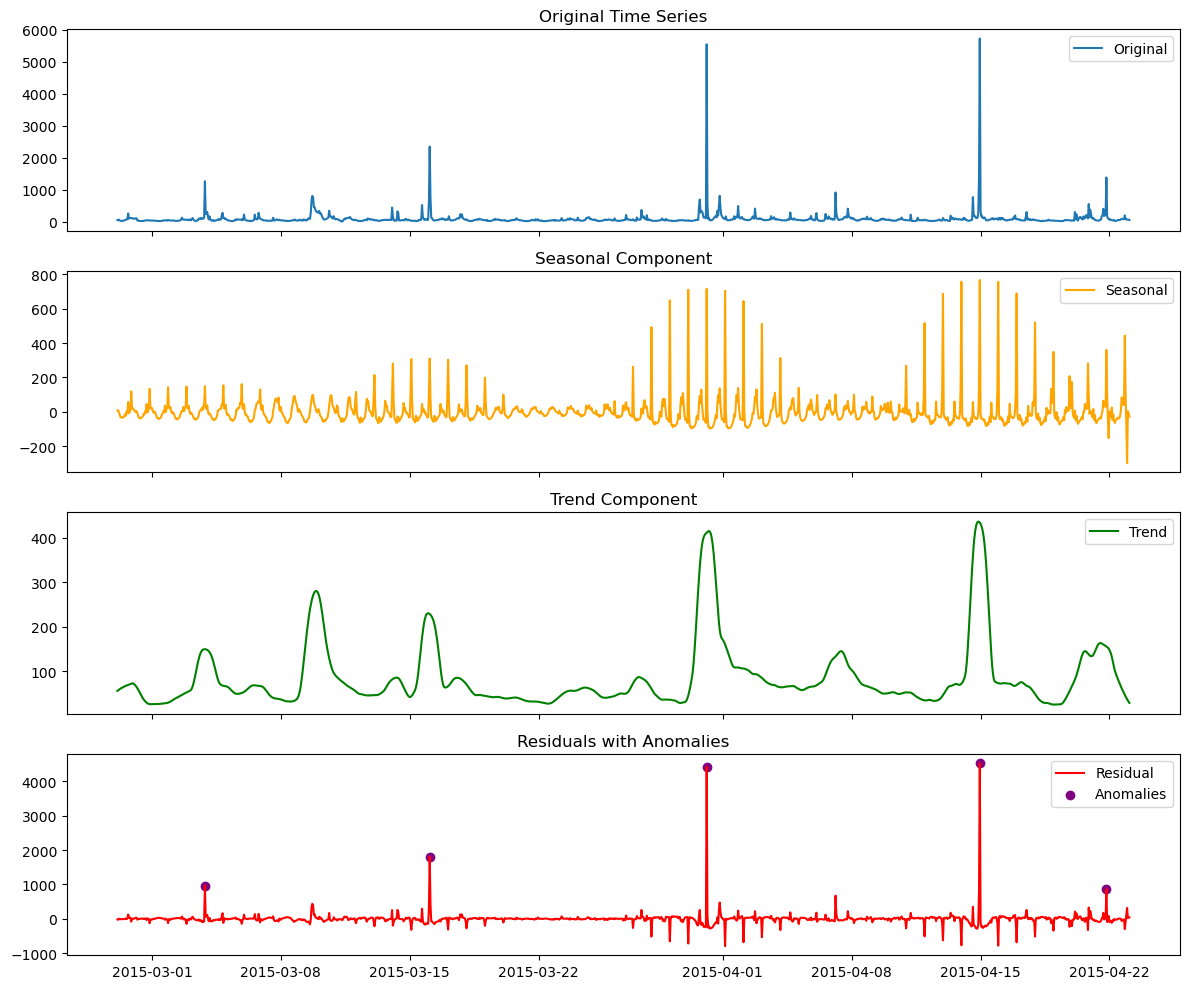

,value,seasonal,trend,residual,anomaly
timestamp,,,,,
2015-03-03 21:00:00,1260.333333,148.968880,149.822121,961.542333,True
2015-03-16 02:00:00,2345.000000,309.680211,228.967303,1806.352486,True
2015-03-31 03:00:00,5547.750000,715.487137,411.389229,4420.873633,True
2015-04-14 23:00:00,5728.750000,766.555353,434.234028,4527.960618,True
2015-04-21 20:00:00,1377.833333,359.639220,156.046379,862.147734,True


In [ ]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import numpy as np

# Convert timestamp to datetime and set it as index
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.set_index('timestamp', inplace=True)

# Resample the data to a regular frequency (e.g., 1 hour)
data_resampled = data['value'].resample('1h').mean().interpolate()  # Interpolating to fill missing values

# Apply STL decomposition on the resampled data
stl = STL(data_resampled, seasonal=13)  # Adjust seasonal component if needed
result = stl.fit()

# Extract components
seasonal = result.seasonal
trend = result.trend
residual = result.resid

# Calculate threshold for anomaly detection
threshold = 3 * residual.std()
anomalies = np.abs(residual) > threshold

# Prepare the dataframe with results
data_resampled = pd.DataFrame({
    'value': data_resampled,
    'seasonal': seasonal,
    'trend': trend,
    'residual': residual,
    'anomaly': anomalies
})

# Plotting the decomposition and anomalies
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
axes[0].plot(data_resampled.index, data_resampled['value'], label='Original')
axes[0].set_title('Original Time Series')
axes[1].plot(data_resampled.index, seasonal, label='Seasonal', color='orange')
axes[1].set_title('Seasonal Component')
axes[2].plot(data_resampled.index, trend, label='Trend', color='green')
axes[2].set_title('Trend Component')
axes[3].plot(data_resampled.index, residual, label='Residual', color='red')
axes[3].scatter(data_resampled.index[anomalies], residual[anomalies], color='purple', label='Anomalies')
axes[3].set_title('Residuals with Anomalies')

for ax in axes:
    ax.legend()
plt.tight_layout()
plt.show()

# Display a few rows with anomalies flagged
data_resampled[data_resampled['anomaly']].head()


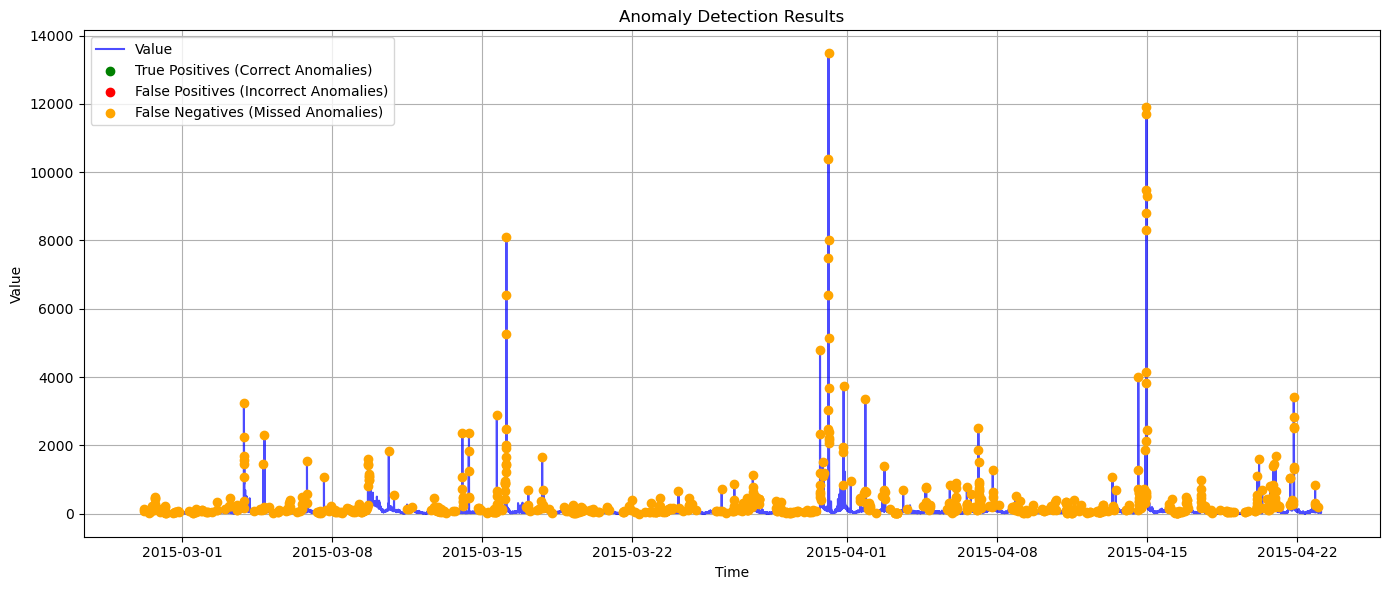

{'True Positives': np.int64(0),
 'False Positives': np.int64(0),
 'False Negatives': np.int64(776),
 'True Negatives': np.int64(15054)}

In [3]:
# Combine original labels and predictions for analysis
data['predicted_anomaly'] = anomalies.reindex(data.index, fill_value=False)

# Categorize anomalies
data['true_positive'] = data['is_anomaly'] & data['predicted_anomaly']
data['false_positive'] = ~data['is_anomaly'] & data['predicted_anomaly']
data['false_negative'] = data['is_anomaly'] & ~data['predicted_anomaly']

# Plot anomalies with distinctions
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['value'], label='Value', color='blue', alpha=0.7)

# Highlight true positives (correctly identified anomalies)
plt.scatter(
    data.index[data['true_positive']],
    data['value'][data['true_positive']],
    color='green',
    label='True Positives (Correct Anomalies)',
    zorder=5
)

# Highlight false positives (incorrectly flagged as anomalies)
plt.scatter(
    data.index[data['false_positive']],
    data['value'][data['false_positive']],
    color='red',
    label='False Positives (Incorrect Anomalies)',
    zorder=5
)

# Highlight false negatives (missed anomalies)
plt.scatter(
    data.index[data['false_negative']],
    data['value'][data['false_negative']],
    color='orange',
    label='False Negatives (Missed Anomalies)',
    zorder=5
)

plt.title('Anomaly Detection Results')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Analysis of errors
false_positive_count = data['false_positive'].sum()
false_negative_count = data['false_negative'].sum()
true_positive_count = data['true_positive'].sum()
true_negative_count = (~data['is_anomaly'] & ~data['predicted_anomaly']).sum()

# Error analysis summary
{
    "True Positives": true_positive_count,
    "False Positives": false_positive_count,
    "False Negatives": false_negative_count,
    "True Negatives": true_negative_count,
}


### Analysis of False Negatives

The high number of false negatives in the anomaly detection results can be attributed to several factors:

1. **Threshold Setting**: What ever the threshold is set to, it is not able to capture the anomalies in the data.

3. **Data Resampling**: The data is resampled to an hourly frequency and interpolated to fill missing values. This resampling might smooth out some of the anomalies, making them harder to detect. Analyzing the data at its original frequency or using a different resampling method might help.

4. **Model Limitations**: The STL decomposition might not be the best model for this specific dataset. Other anomaly detection methods, such as machine learning-based approaches, might perform better in identifying anomalies.

5. **Data Quality**: The quality of the input data can significantly impact the results. If there are inconsistencies, noise, or missing values in the data, it can lead to inaccurate anomaly detection. Ensuring data quality through preprocessing steps can improve the results.

6. **Anomaly Definition**: The definition of what constitutes an anomaly might need to be revisited. If the criteria for labeling anomalies are too strict or not well-defined, it can lead to a high number of false negatives.